# Fitting of sequential 1D cuts

After a spectrum has been measured, it is sensible to extract some of the physical quantities of excitations. In this tutorial, one possible method of doing so by the use of QELine as well as LMFIT is presented. The data is the MnF2 data set where only as subset of the data is used. Specifically from 4.8 meV to 6.9 meV and the parameters wanted are the positions and widths of the magnon along two cuts in $Q$. More specifically, there will be performed a cut from (-1,0,-67) RLU to (-1,0,1) RLU to (0,0,1) RLU. For each of the two segments, the data is split into horizontal (energy) slices of same energy width and Gaussians are used to model the spin wave line shapes. Below is the data as seen before the fitting routine has been performed.

In [1]:
%matplotlib inline
from MJOLNIR.Data import DataSet
from MJOLNIR import _tools # Usefull tools useful across MJOLNIR
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel

plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 200


numbers = '483-490,492-500'
files = _tools.fileListGenerator(numbers,r'C:\Users\lass_j\Documents\CAMEA2018',year=2018)
ds = DataSet.DataSet(files)
ds.convertDataFile(binning=8)


# utility function to return points in array before a given value
def index_of(arrval, value):
    """Return index of array *at or below* value."""
    if value < min(arrval):
        return 0
    if np.sum(np.diff(arrval))>0: # Positive change
        return max(np.where(arrval <= value)[0])
    else:
        return max(np.where(arrval >= value)[0])

Define the two cuts to be performed; between (-1,0,-1.2) and (-1,0,1) further on to (0,0,1)

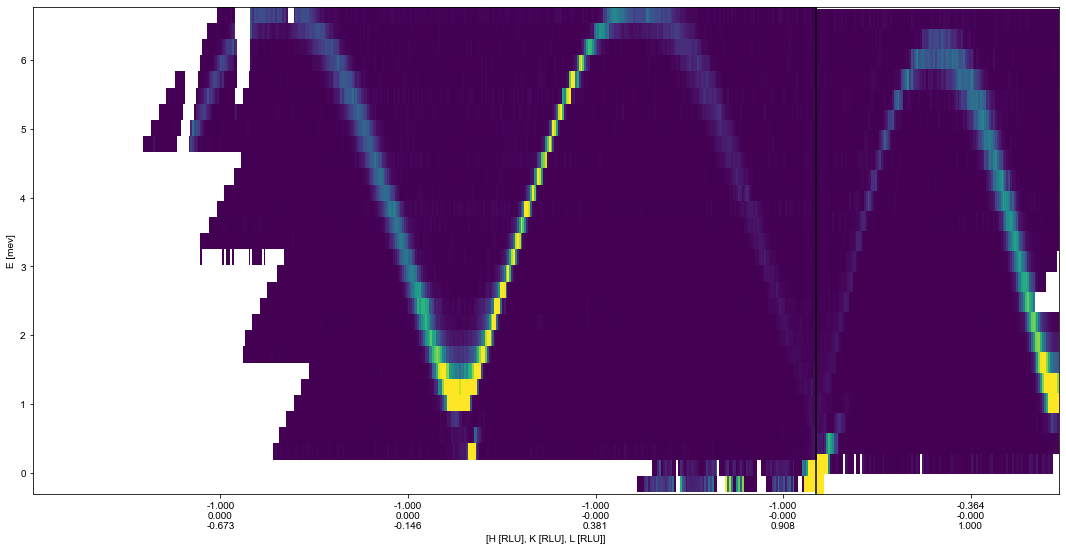

In [2]:
%matplotlib inline
# Define qut in Q space
q1 = [-1,0,-1.2]
q2 = [-1,0,1.0]
q3 = [0,0,1.0]

# Create two different energy ranges for the cut from q1 to q2 and q2 to q3
EBins = np.array([np.linspace(ds.energy.min(),ds.energy.max(),31),np.linspace(ds.energy.min(),ds.energy.max(),25)],dtype=object)

# Perform the cut and plot it. Returns a cutObject
ax,Data,Bin = ds.plotCutQELine(QPoints=[q1,q2,q3],width=0.05,minPixel=0.01,EnergyBins=EBins,plotSeperator=True) #

ax.set_clim(0,5e-6)
ax.get_figure().set_size_inches(16,9)

The following code is rahter complex but in a larger picture, first the cut between $q_1$ and $q_2$ is dealt with followed by $q_2$ and $q_3$. For each of the cuts, the returned data (in the form of Pandas Dataframes) are grouped together in energy slices, i.e. same energy transfers are grouped togehter. 

For the first cut, a fitting function is created consisting 3 Gaussians while for the second two Gaussians are used. For both cuts, energies below 1.6 meV are ignored while only for the second cut energies above 6.1 meV. 

For each energy cut the suitable model is fitted and the parameters are extracted and saved in the <code>center3D</code> and <code>center3DErr</code>. Lastly, the points are plotted on top of the figure.

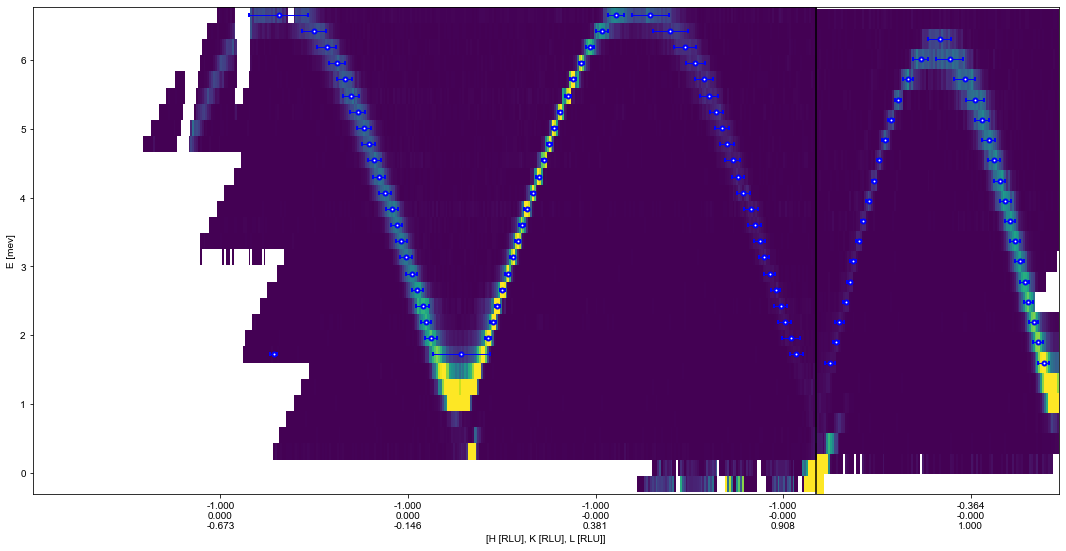

In [3]:
# Define plotting parameters for error bar plot to be created
ErrorBarKwargs = {'markersize':4, 'capsize':2,'elinewidth':1,'markeredgewidth':2,'mfc':'white','fmt':'o'}

out = [] # Holder for fitting results

# Loop through the different cuts
for ID,_cutdata in enumerate(Data):
# ID: which segment, either 0: q1->q2, or 1: q2->q3
# _data: pandas frame containing data for this cut

    for _,_data in _cutdata.groupby('Energy'):
        # Transpose as to easier perform fit
        x = _data[['H','K','L','Energy']]

        # Calculate intensity and remove points that has not been measured

        y = _data['Int'].values
        NoNNans = (_data['Monitor']>0).values

        y = y[NoNNans]
        x = x[NoNNans]


        # Fit depends on which cut is in question
        if ID==0:
            # Fit consists of three 1D Gaussians
            gauss1 = GaussianModel(prefix='g1_')
            gauss2 = GaussianModel(prefix='g2_') # Give the Gaussians different prefixes
            gauss3 = GaussianModel(prefix='g3_')

            # Model is simply the sum of these
            mod = gauss1 + gauss2 + gauss3

            # Direction along which to fit
            fittingX = x['L']

            E = x['Energy'].values[0]
            if E<1.6:
                continue

            # Cut out portions to make use of the automatic parameter estimation
            ix1 = fittingX< -0.1 # All points before -0.1 is for first Gaussian
            ix2 = np.logical_and(fittingX> -0.1,fittingX<0.5) # Between ix1 and ix2 is second Gaussian
            ix3 = fittingX>0.5 # values bigger than 0.5
            # Third Gaussian is from 0.5 and the rest.

            # Use lmfit's parameter starting guess
            pars = gauss1.guess(y[ix1],x=fittingX[ix1].values)
            pars.update(gauss2.guess(y[ix2],x=fittingX[ix2].values))
            pars.update(gauss3.guess(y[ix3],x=fittingX[ix3].values))

        elif ID == 1:

            # Repeat procedure from above for second segment with only 2 Gaussians or 1 depending on energy
            fittingX = x['H'].values
            gauss1 = GaussianModel(prefix='g1_')
            E = x['Energy'].values[0]
            if E<1.6:
                continue
            if E<6.1:

                gauss2 = GaussianModel(prefix='g2_')

                mod = gauss1 + gauss2

                ix1 = fittingX<-0.5
                ix2 = np.logical_not(ix1)

                pars = gauss1.guess(y[ix1],x=fittingX[ix1])
                pars.update(gauss2.guess(y[ix2],x=fittingX[ix2]))
            elif E<6.45:
                mod = gauss1
                pars = gauss1.guess(y,x=fittingX)
            else:
                continue

        # Perform fit and save results in the 'out' array
        result = mod.fit(y, pars, x=fittingX)
        out.append(result)

        # For plotting Centres and widths are needed (Their errors are extracted as well, but unused)
        centres = []
        centres_err = []
        widths = []
        widths_err = []
        for parname, par in result.params.items():
            if 'center' in parname:
                centres.append(par.value)
                centres_err.append(par.stderr)
            if 'sigma' in parname:
                widths.append(par.value)
                widths_err.append(par.stderr)

        # Depending on segment, the centres of the Gaussians are either [-1,0,c] or [c,0,-1]
        # 'Errors' refers to the errorbars and are in this case plotted as the widths
        if ID == 0:
            Center3D    = np.array([[-1.0,0,c] for c in centres])
            Center3DErr = np.array([[-1.0,0,c+err] for c,err in zip(centres,widths)])

        elif ID == 1:
            Center3D    = np.array([[c,0,1] for c in centres])
            Center3DErr = np.array([[c+err,0,1] for c,err in zip(centres,widths)])

        # Calculate the position along the plot for the HKL points.
        XPosition = np.concatenate([ax.calculatePositionInv(c.reshape(1,-1)) for c in Center3D])
        XPositionErr = np.concatenate([ax.calculatePositionInv(CE.reshape(1,-1)) for CE in Center3DErr])-XPosition
        # The above is needed as an axis only has one x-axis and plotting multiple segments require some trickery,
        # resulting in rescaling and offsets. It is all taken care of in the converterFunction of the axis.


        ax.errorbar(XPosition,[x.values[0][-1]]*len(XPosition),xerr=XPositionErr,c = 'b', **ErrorBarKwargs)
        # plot the errorbar on top of intensity data
        
ax.get_figure()

If one does not like to work with pandas DataFrames, one can convert them into a set of numpy arrays. However, this then requires the user to deal with all of the indices themself. Further, if LMFIT is not your cup of tea, many other fitting routines exist for Python, e.g. the <code>scipy.optimize.curve_fit</code>.